In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from fycharts.SpotifyCharts import SpotifyCharts
import sqlalchemy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

In [2]:
italy_17_19 = pd.read_pickle('../data/it_17_19_v50_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_v50_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_v50_feat.pkl')

italy_20 = pd.read_pickle('../data/it_20_v50_feat.pkl')
spain_20 = pd.read_pickle('../data/sp_20_v50_feat.pkl')
greece_20 = pd.read_pickle('../data/gr_20_v50_feat.pkl')

In [3]:
spain_20.tail()

,Position,Track Name,Artist,region,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,,,,
2021-02-13,46,Hasta Abajo,Kevin Roldan,es,4PEfJZpVjdclfzZ9XO8uDw,0.714,0.671,5,-5.119,1,0.3620,0.28900,0.000000,0.3250,0.6410,169.732,229827,4
2021-02-13,47,Strange (feat. Hillary Smith),Kris Bowers,es,2bPWLtJe3v33z1j40sWB8a,0.251,0.150,2,-15.076,1,0.0342,0.98900,0.972000,0.1130,0.0727,70.453,198640,4
2021-02-13,48,Hecha Pa' Mi,Boza,es,3VvA1wSxukMLsvXoXtlwWx,0.725,0.756,4,-5.013,1,0.0572,0.36200,0.000685,0.1030,0.8280,100.070,186133,4
2021-02-13,49,La Luz - A COLORS SHOW,María José Llergo,es,5jRnVQbjB6qgN3MARS4xw7,0.722,0.357,9,-10.487,0,0.0996,0.81400,0.155000,0.0863,0.6410,149.895,191599,4
2021-02-13,50,Boku no Sensou - TV Size,Shinsei Kamattechan,es,3tRPfCFAEv6wWyQO0YnGGV,0.447,0.891,9,-4.776,1,0.0788,0.00447,0.000905,0.3900,0.5170,143.976,90960,4


**Resampling by month**

_`rm` denotes resampling by month._ 

In [4]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

rm_italy_20 = italy_20.resample("M").mean()
rm_spain_20 = spain_20.resample("M").mean()
rm_greece_20 = greece_20.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [5]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

rw_italy_20 = italy_20.resample("W").mean()
rw_spain_20 = spain_20.resample("W").mean()
rw_greece_20 = greece_20.resample("W").mean()

#### Combining weekly resampled data for all years (2017-2020)

In [6]:
alltime_italy = pd.concat([italy_17_19, italy_20])
alltime_spain = pd.concat([spain_17_19, spain_20])
alltime_greece = pd.concat([greece_17_19, greece_20])

alltime_rw_italy = alltime_italy.resample("W").mean()
alltime_rw_spain = alltime_spain.resample("W").mean()
alltime_rw_greece = alltime_greece.resample("W").mean()

### Dickey-Fuller and Differencing 

Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [7]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [50]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 'lags_used'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [ ]:
adfuller(alltime_rw)

In [51]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}:\n{interpret_dftest(adfuller(alltime_rw_italy[feature]))}')

Dickey-Fuller Interpretation for danceability:
Test Statistic   -3.013333
p-value           0.033668
lags_used         4.000000
dtype: float64
Dickey-Fuller Interpretation for energy:
Test Statistic   -3.470516
p-value           0.008777
lags_used         9.000000
dtype: float64
Dickey-Fuller Interpretation for key:
Test Statistic   -6.335745e+00
p-value           2.833617e-08
lags_used         4.000000e+00
dtype: float64
Dickey-Fuller Interpretation for loudness:
Test Statistic   -3.355416
p-value           0.012576
lags_used         7.000000
dtype: float64
Dickey-Fuller Interpretation for mode:
Test Statistic   -6.787062e+00
p-value           2.417084e-09
lags_used         0.000000e+00
dtype: float64
Dickey-Fuller Interpretation for speechiness:
Test Statistic   -4.108187
p-value           0.000939
lags_used         2.000000
dtype: float64
Dickey-Fuller Interpretation for acousticness:
Test Statistic   -4.022911
p-value           0.001295
lags_used         2.000000
dtype: float64
Dic

### DataFrame with once-differenced data

In [10]:
lag_df_italy = alltime_rw_italy.copy()

In [11]:
for feature in audio_features: 
    lag_df_italy[f'{feature}_once_differenced'] = lag_df_italy[feature].diff(1).fillna(0)

In [12]:
lag_df_italy.tail()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2021-01-17,25.5,0.648654,0.575126,5.777143,-7.367766,0.591429,0.110776,0.358029,0.019525,0.186532,...,-0.019957,0.174286,0.367906,-0.020000,-0.009854,0.024697,-0.001551,0.015144,-0.007326,0.952746
2021-01-24,25.5,0.657583,0.601891,5.514286,-7.057797,0.622857,0.112212,0.363183,0.019110,0.216798,...,0.026766,-0.262857,0.309969,0.031429,0.001436,0.005155,-0.000415,0.030267,0.029103,2.151463
2021-01-31,25.5,0.658066,0.605014,5.222857,-6.992654,0.648571,0.110351,0.341578,0.037043,0.217935,...,0.003123,-0.291429,0.065143,0.025714,-0.001861,-0.021605,0.017933,0.001137,0.001768,-1.597763
2021-02-07,25.5,0.666561,0.634389,5.402857,-6.677991,0.680000,0.109192,0.268234,0.035348,0.223654,...,0.029374,0.180000,0.314663,0.031429,-0.001159,-0.073344,-0.001695,0.005719,-0.006398,3.285271
2021-02-14,25.5,0.671104,0.647343,5.516667,-6.842603,0.656667,0.120716,0.277941,0.054173,0.220087,...,0.012955,0.113810,-0.164612,-0.023333,0.011523,0.009707,0.018826,-0.003567,0.049983,1.041837


_Dickey-Fuller on lag dataframe_

In [13]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, once-differenced:\n{interpret_dftest(adfuller(lag_df_italy[feature].diff(1).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, once-differenced:
Test Statistic   -9.142255e+00
p-value           2.828632e-15
dtype: float64
Dickey-Fuller Interpretation for energy, once-differenced:
Test Statistic   -6.782611e+00
p-value           2.477455e-09
dtype: float64
Dickey-Fuller Interpretation for key, once-differenced:
Test Statistic   -8.518281e+00
p-value           1.118537e-13
dtype: float64
Dickey-Fuller Interpretation for loudness, once-differenced:
Test Statistic   -7.002232e+00
p-value           7.272028e-10
dtype: float64
Dickey-Fuller Interpretation for mode, once-differenced:
Test Statistic   -9.845662e+00
p-value           4.627101e-17
dtype: float64
Dickey-Fuller Interpretation for speechiness, once-differenced:
Test Statistic   -8.291616e+00
p-value           4.246658e-13
dtype: float64
Dickey-Fuller Interpretation for acousticness, once-differenced:
Test Statistic   -1.160866e+01
p-value           2.544491e-21
dtype: float64
Dickey-Fuller Interpretation for i

In [14]:
interpret_dftest(adfuller(lag_df_italy['tempo_once_differenced']))

Test Statistic   -6.454214e+00
p-value           1.497350e-08
dtype: float64

In [15]:
interpret_dftest(adfuller(lag_df_italy['tempo'].diff(1).fillna(0)))

Test Statistic   -6.454214e+00
p-value           1.497350e-08
dtype: float64

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

In [16]:
from pmdarima.arima.utils import ndiffs

In [17]:
ndiffs(alltime_italy['acousticness'], test = 'adf')

0

In [18]:
ndiffs(alltime_rw_italy['acousticness'], test = 'adf' )

0

In [19]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 0
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 0
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for tempo stationarity w/ adf test: 0


In [20]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_rw_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 1
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 1
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for tempo stationarity w/ adf test: 0


In [21]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 1
ndiffs for loudness stationarity w/ kpss test: 1
ndiffs for mode stationarity w/ kpss test: 1
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for tempo stationarity w/ kpss test: 1


In [22]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_rw_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 0
ndiffs for loudness stationarity w/ kpss test: 0
ndiffs for mode stationarity w/ kpss test: 0
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for tempo stationarity w/ kpss test: 0


### Finding `p`, `d`, and `q` values

_Using only the five audio features that are the most relevant or show some sort of pattern_ 

In [23]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'tempo']

_Building dataframe with `ndifffs` for stationarity for each feature_

In [24]:
ndiff_dict = {
    'audio_feature':[],
    'ndiffs for stationarity':[]    
}

for feature in five_features:
    ndiff_dict['audio_feature'].append(feature)
    ndiff_dict['ndiffs for stationarity'].append(ndiffs(alltime_rw_italy[feature], test= "adf"))

ndiff_df = pd.DataFrame(ndiff_dict)
ndiff_df

,audio_feature,ndiffs for stationarity
0,danceability,1
1,mode,1
2,acousticness,0
3,valence,0
4,tempo,0


In [25]:
arima_dict = {
    'audio_feature':[],
    'AIC':[],
    'ndiffs(d)':[],
    'best_p':[],
    'best_q':[],
    'order':[],
    'ARIMA_model':[]
}

def find_p_and_q(df, feature, n=6):
    
    train = df[feature][0:162]
    
    d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]

    # starting with large start AIC
    best_aic = 99 * (10 * 16)
    # creating variables to store best values ofd p and q 
    best_p = 0
    best_q = 0 

    # use nested for loop to iterate over values of p and q
    for p in range(n):

        for q in range(n):

            # insert try and and except statements
            try: 

                # fitting on ARIMA(p, 1, q) model 
                print(f'Attempting to fit ARIMA({p}, {d}, {q})')

                # instantiate ARIMA model
                arima = ARIMA(train, order=(p,d,q))

                # fit ARIMA model 
                model = arima.fit()

                # print out AIC for ARIMA(p, 1, q) model 
                print(f'For {feature}, the AIC for ARIMA({p},{d},{q}) is: {model.aic}')

                # Is this current model's AIC better than the OF best_aic? 
                if model.aic < best_aic:
                    # we want aic to be lower so we are setting a high aic and hoping for something lower 

                    # if it is, we overwrite the best_aic, best_p, and best_q
                    best_aic = model.aic
                    best_p = p 
                    best_q = q

            except:
                pass 

        order = (best_p, d, best_q)
    
    arima_dict['audio_feature'].append(feature)
    arima_dict['AIC'].append(best_aic)
    arima_dict['ndiffs(d)'].append(d)
    arima_dict['best_p'].append(best_p)
    arima_dict['best_q'].append(best_q)
    arima_dict['order'].append(order)
    arima_dict['ARIMA_model'].append(f'ARIMA({best_p},{d},{best_q})')

    print()
    print(f'{feature.capitalize()} MODEL FINISHED!')
    print(f'The model for {feature} that minimizes AIC on the training data is the ARIMA({best_p},{d},{best_q}).')
    print(f'The model has an aIC of {best_aic}.')
    print()

In [26]:
arima_dict

{'audio_feature': [],
 'AIC': [],
 'ndiffs(d)': [],
 'best_p': [],
 'best_q': [],
 'order': [],
 'ARIMA_model': []}

In [27]:
find_p_and_q(alltime_rw_italy, 'danceability')

Attempting to fit ARIMA(0, 1, 0)
For danceability, the AIC for ARIMA(0,1,0) is: -725.8837710601316
Attempting to fit ARIMA(0, 1, 1)
For danceability, the AIC for ARIMA(0,1,1) is: -741.6315380820415
Attempting to fit ARIMA(0, 1, 2)
For danceability, the AIC for ARIMA(0,1,2) is: -741.0303860542913
Attempting to fit ARIMA(0, 1, 3)
For danceability, the AIC for ARIMA(0,1,3) is: -740.5524780247699
Attempting to fit ARIMA(0, 1, 4)
For danceability, the AIC for ARIMA(0,1,4) is: -739.7901121166813
Attempting to fit ARIMA(0, 1, 5)
For danceability, the AIC for ARIMA(0,1,5) is: -737.8819998993706
Attempting to fit ARIMA(1, 1, 0)
For danceability, the AIC for ARIMA(1,1,0) is: -737.8870828958725
Attempting to fit ARIMA(1, 1, 1)
For danceability, the AIC for ARIMA(1,1,1) is: -742.5043022824921
Attempting to fit ARIMA(1, 1, 2)
For danceability, the AIC for ARIMA(1,1,2) is: -746.7977296013453
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(1, 1, 5)
Attempting

In [28]:
for feature in five_features:
    find_p_and_q(alltime_rw_italy, feature)

Attempting to fit ARIMA(0, 1, 0)
For danceability, the AIC for ARIMA(0,1,0) is: -725.8837710601316
Attempting to fit ARIMA(0, 1, 1)
For danceability, the AIC for ARIMA(0,1,1) is: -741.6315380820415
Attempting to fit ARIMA(0, 1, 2)
For danceability, the AIC for ARIMA(0,1,2) is: -741.0303860542913
Attempting to fit ARIMA(0, 1, 3)
For danceability, the AIC for ARIMA(0,1,3) is: -740.5524780247699
Attempting to fit ARIMA(0, 1, 4)
For danceability, the AIC for ARIMA(0,1,4) is: -739.7901121166813
Attempting to fit ARIMA(0, 1, 5)
For danceability, the AIC for ARIMA(0,1,5) is: -737.8819998993706
Attempting to fit ARIMA(1, 1, 0)
For danceability, the AIC for ARIMA(1,1,0) is: -737.8870828958725
Attempting to fit ARIMA(1, 1, 1)
For danceability, the AIC for ARIMA(1,1,1) is: -742.5043022824921
Attempting to fit ARIMA(1, 1, 2)
For danceability, the AIC for ARIMA(1,1,2) is: -746.7977296013453
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(1, 1, 5)
Attempting

In [29]:
arima_param_df = pd.DataFrame(arima_dict)
arima_param_df

,audio_feature,AIC,ndiffs(d),best_p,best_q,order,ARIMA_model
0,danceability,-746.797730,1,1,2,"(1, 1, 2)","ARIMA(1,1,2)"
1,danceability,-746.797730,1,1,2,"(1, 1, 2)","ARIMA(1,1,2)"
2,mode,-446.531723,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)"
3,acousticness,-619.986170,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)"
4,valence,-647.409633,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)"
5,tempo,796.904884,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)"


In [30]:
arima_param_df = arima_param_df.drop([0])
arima_param_df

,audio_feature,AIC,ndiffs(d),best_p,best_q,order,ARIMA_model
1,danceability,-746.797730,1,1,2,"(1, 1, 2)","ARIMA(1,1,2)"
2,mode,-446.531723,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)"
3,acousticness,-619.986170,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)"
4,valence,-647.409633,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)"
5,tempo,796.904884,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)"


### Building dataframes in year-long chunks

In [31]:
lag_df_italy

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,...,0.005019,-0.237143,0.337877,0.117143,0.009925,0.052356,0.120898,0.003355,-0.075560,3.052389
2017-01-15,25.5,0.590561,0.584263,5.025714,-8.433451,0.625714,0.091436,0.340648,0.141121,0.204428,...,-0.011853,-0.577143,0.236871,-0.091429,-0.000159,-0.014711,-0.041355,0.028811,0.011662,-0.406554
2017-01-22,25.5,0.570760,0.618591,4.497143,-7.809969,0.588571,0.093505,0.348782,0.111421,0.163771,...,0.034328,-0.528571,0.623483,-0.037143,0.002069,0.008134,-0.029699,-0.040657,-0.005162,1.572900
2017-01-29,25.5,0.549560,0.672368,4.888571,-6.910569,0.705714,0.087994,0.302466,0.069887,0.175481,...,0.053777,0.391429,0.899400,0.117143,-0.005511,-0.046316,-0.041534,0.011710,0.072090,2.910506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-17,25.5,0.648654,0.575126,5.777143,-7.367766,0.591429,0.110776,0.358029,0.019525,0.186532,...,-0.019957,0.174286,0.367906,-0.020000,-0.009854,0.024697,-0.001551,0.015144,-0.007326,0.952746
2021-01-24,25.5,0.657583,0.601891,5.514286,-7.057797,0.622857,0.112212,0.363183,0.019110,0.216798,...,0.026766,-0.262857,0.309969,0.031429,0.001436,0.005155,-0.000415,0.030267,0.029103,2.151463
2021-01-31,25.5,0.658066,0.605014,5.222857,-6.992654,0.648571,0.110351,0.341578,0.037043,0.217935,...,0.003123,-0.291429,0.065143,0.025714,-0.001861,-0.021605,0.017933,0.001137,0.001768,-1.597763


In [32]:
it_rw_17 = lag_df_italy[0:53]
it_rw_18 = lag_df_italy[53:105]
it_rw_19 = lag_df_italy[105:158]

In [33]:
it_rw_17.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2017-12-24,25.5,0.612843,0.674063,5.302857,-6.309091,0.657143,0.123394,0.253601,0.013014,0.179737,...,-0.017777,0.740000,-0.155729,0.045714,0.006183,-0.011564,-0.003578,0.025182,-0.027138,-2.956506
2017-12-31,25.5,0.610449,0.656787,5.637143,-6.322729,0.688571,0.102279,0.209149,0.022378,0.171537,...,-0.017276,0.334286,-0.013637,0.031429,-0.021116,-0.044452,0.009364,-0.008199,-0.028425,7.831740


In [34]:
it_rw_18.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2018-12-23,25.5,0.652526,0.62446,5.345714,-7.126363,0.548571,0.098575,0.315516,0.058491,0.126928,...,0.040456,0.037143,0.448194,-0.022857,0.004563,-0.063911,-0.005905,-0.018910,0.038279,3.064040
2018-12-30,25.5,0.637171,0.63514,4.971429,-6.814571,0.528571,0.104640,0.342631,0.066215,0.139117,...,0.010680,-0.374286,0.311791,-0.020000,0.006065,0.027116,0.007724,0.012189,-0.004197,3.749371


In [35]:
it_rw_19.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2019-12-29,25.5,0.666363,0.610831,6.125714,-7.189337,0.637143,0.109331,0.278767,0.041290,0.171111,...,0.013563,-0.114286,-0.110054,-0.031429,0.010711,-0.032194,0.026400,0.002468,0.021791,-0.141337
2020-01-05,25.5,0.695900,0.643483,6.314286,-6.612169,0.634286,0.127259,0.225605,0.030068,0.184051,...,0.032651,0.188571,0.577169,-0.002857,0.017928,-0.053161,-0.011222,0.012940,0.015639,0.658831


In [36]:
arima_param_df

,audio_feature,AIC,ndiffs(d),best_p,best_q,order,ARIMA_model
1,danceability,-746.797730,1,1,2,"(1, 1, 2)","ARIMA(1,1,2)"
2,mode,-446.531723,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)"
3,acousticness,-619.986170,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)"
4,valence,-647.409633,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)"
5,tempo,796.904884,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)"


In [37]:
arima_param_df.loc[arima_param_df['audio_feature'] == 'danceability', 'order'].iloc[0]

(1, 1, 2)

In [ ]:
ndiff_df.loc[ndiff_df['audio_feature'] == 'danceability', 'ndiffs for stationarity'].iloc[0]

In [70]:
def arima_fit_predict_evaluate(df, feature, year, order, d=0):
    
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    # d = ndiff_df.loc[ndiff_df['audio_feature'] == ndiff_feature, 'ndiffs for stationarity'].iloc[0]

    # find order from arima parameters dataframe 
    # order = arima_param_df.loc[arima_param_df['audio_feature'] == ndiff_feature, 'order'].iloc[0]
   
    # instantiate ARIMA model
    model = ARIMA(train, order=order)

    # fit ARIMA model
    arima = model.fit()
    
    # get predictions for train and test sets 
    preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1], typ='levels')
    preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1], typ='levels')
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'test_rmse'] = test_rmse
    
    # calculate residuals
    residuals = test - preds_test
    
    return train, test, preds_test, residuals

In [72]:
def arima_plot(train, test, preds_test, title='title', figsize=(15,5)):
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # plot confidence interval 
#     ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
#     plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

In [73]:
arima_param_df

,audio_feature,AIC,ndiffs(d),best_p,best_q,order,ARIMA_model,train_rmse,test_rmse
1,danceability,-746.797730,1,1,2,"(1, 1, 2)","ARIMA(1,1,2)",0.618315,0.603174
2,mode,-446.531723,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",0.070201,0.078988
3,acousticness,-619.986170,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",NaN,NaN
4,valence,-647.409633,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",NaN,NaN
5,tempo,796.904884,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)",NaN,NaN


### Creating and plotting ARIMA Models - 2017

In [74]:
it_rw_17.head()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,...,0.005019,-0.237143,0.337877,0.117143,0.009925,0.052356,0.120898,0.003355,-0.075560,3.052389
2017-01-15,25.5,0.590561,0.584263,5.025714,-8.433451,0.625714,0.091436,0.340648,0.141121,0.204428,...,-0.011853,-0.577143,0.236871,-0.091429,-0.000159,-0.014711,-0.041355,0.028811,0.011662,-0.406554
2017-01-22,25.5,0.570760,0.618591,4.497143,-7.809969,0.588571,0.093505,0.348782,0.111421,0.163771,...,0.034328,-0.528571,0.623483,-0.037143,0.002069,0.008134,-0.029699,-0.040657,-0.005162,1.572900
2017-01-29,25.5,0.549560,0.672368,4.888571,-6.910569,0.705714,0.087994,0.302466,0.069887,0.175481,...,0.053777,0.391429,0.899400,0.117143,-0.005511,-0.046316,-0.041534,0.011710,0.072090,2.910506


Danceability train RMSE (2017) - ARIMA((1, 1, 2)): 0.025578078192420372
Danceability test RMSE (2017) - ARIMA((1, 1, 2)): 0.033635247962769725


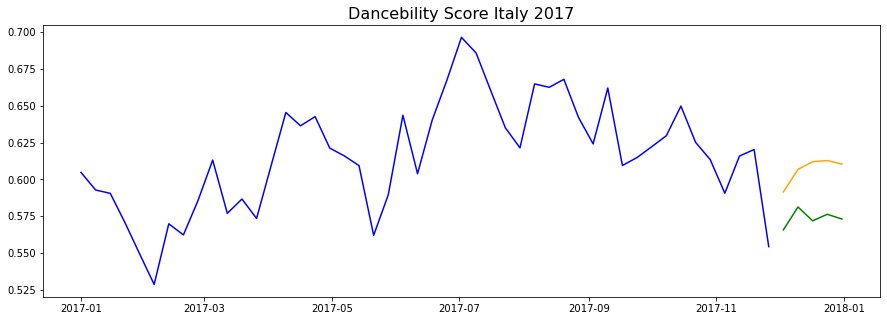

In [75]:
dance_train, dance_test, dance_preds, dance_resids = arima_fit_predict_evaluate(it_rw_17, 'danceability', 2017, order=(1,1,2), d=1)

arima_plot(dance_train, dance_test, dance_preds, title='Dancebility Score Italy 2017')

In [76]:
# def plot_predict(df, feature, year, order, d=0, title='title'):
    
#     train, test, residuals, preds_test = arima_fit_predict_evaluate(train, test, residuals, preds_test)
    
#     arima(train, test, preds_test, title='title', figsize=(15,5))

# plot_predict(it_rw_17, 'danceability_once_differenced', 2017, order=(1,0,2), d=0)

Mode train RMSE (2017) - ARIMA((4, 0, 3)): 0.07020094335386197
Mode test RMSE (2017) - ARIMA((4, 0, 3)): 0.07898751915408961


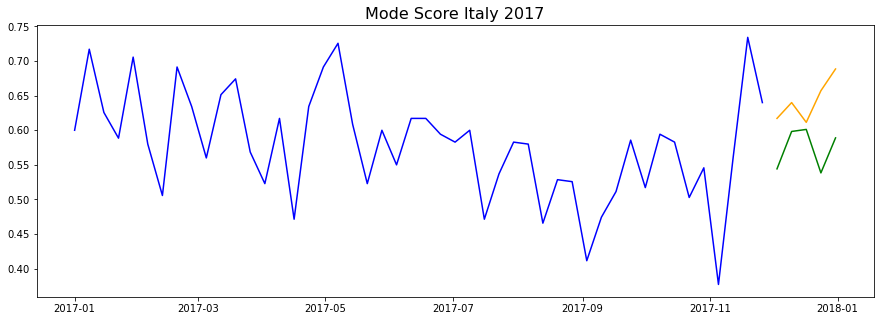

In [78]:
mode_train, mode_test, mode_preds, mode_resids = arima_fit_predict_evaluate(it_rw_17, 'mode', 2017, order=(4,0,3), d=0)

arima_plot(mode_train, mode_test, mode_preds, title='Mode Score Italy 2017')

Acousticness train RMSE (2017) - ARIMA((3, 0, 2)): 0.038503210673536924
Acousticness test RMSE (2017) - ARIMA((3, 0, 2)): 0.031290359571656025


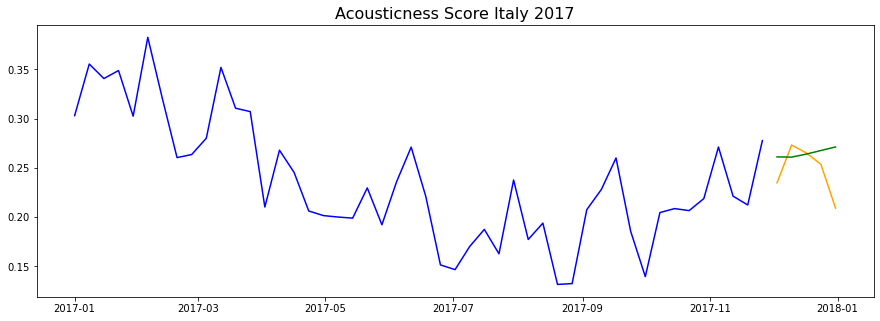

In [79]:
acoustic_train, acoustic_test, acoustic_preds, acoustic_resids = arima_fit_predict_evaluate(it_rw_17, 'acousticness', 2017, order=(3,0,2), d=0)

arima_plot(acoustic_train, acoustic_test, acoustic_preds, title='Acousticness Score Italy 2017')

Valence train RMSE (2017) - ARIMA((2, 0, 2)): 0.035572561609325974
Valence test RMSE (2017) - ARIMA((2, 0, 2)): 0.03332529150268263


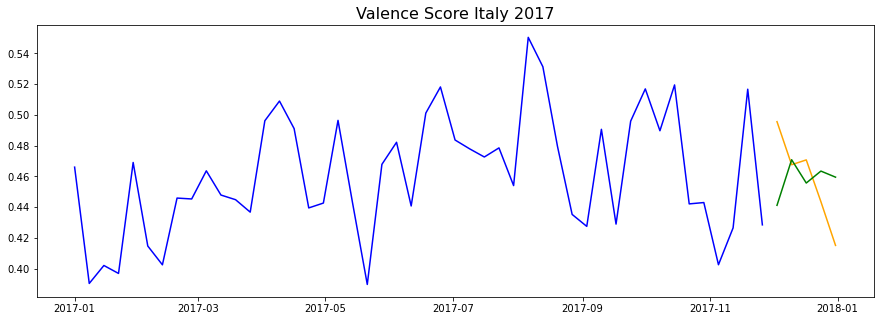

In [80]:
valence_train, valence_test, valence_preds, valence_resids = arima_fit_predict_evaluate(it_rw_17, 'valence', 2017, order=(2,0,2), d=0)

arima_plot(valence_train, valence_test, valence_preds, title='Valence Score Italy 2017')

Tempo train RMSE (2017) - ARIMA((0, 0, 5)): 2.937924521744971
Tempo test RMSE (2017) - ARIMA((0, 0, 5)): 7.1202523963668725


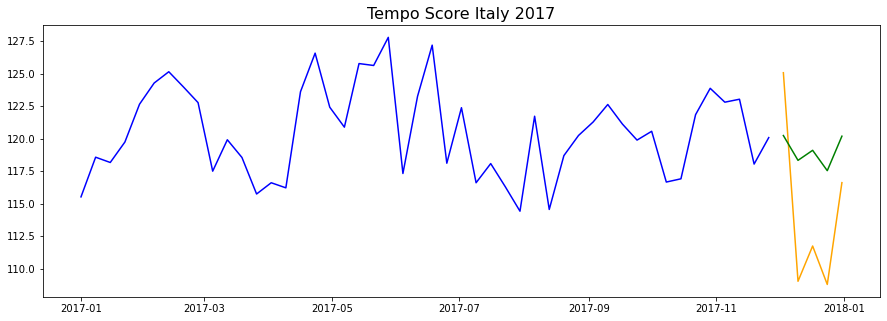

In [81]:
tempo_train, tempo_test, tempo_preds, tempo_resids = arima_fit_predict_evaluate(it_rw_17, 'tempo', 2017, order=(0,0,5), d=0)

arima_plot(tempo_train, tempo_test, tempo_preds, title='Tempo Score Italy 2017')

### Attempting SARIMAX model 

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
P, D, Q, S = 2, 0 ,2, 52
train = it_rw_17['valence'][0:48]
test = it_rw_17['valence'][48:]

In [51]:
sarima = SARIMAX(endog = train, order = (2, 0, 2), seasonal_order = (P, D, Q, S), exog=).fit()
# sarima_pred = sarima.predict(start=start, end = end)

In [52]:
sarima_preds_train = sarima.predict(start=train.index[0], end=train.index[-1])
sarima_preds_test = sarima.predict(start=test.index[0], end=test.index[-1])

In [53]:
print(f'RMSE = {round(mean_squared_error(test, sarima_preds_test)**.5, 2)}')

RMSE = 0.05


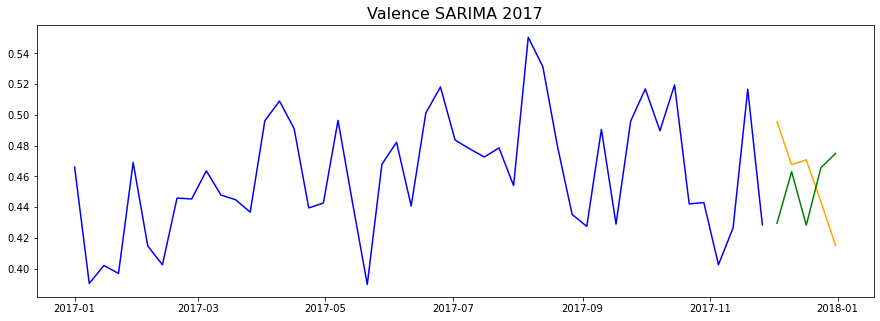

In [54]:
arima_plot(train, test, sarima_preds_test, title="Valence SARIMA 2017")

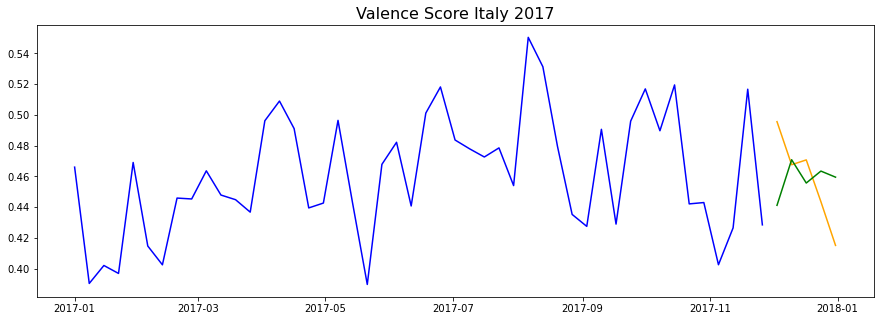

In [55]:
arima_plot(valence_train, valence_test, valence_preds, title='Valence Score Italy 2017')

## SARIMAX  

#### Incorporating Exogenous Variables

_SARIMAX for danceability with no exogenous variables_

0.024446620670556092
0.026355071927261404


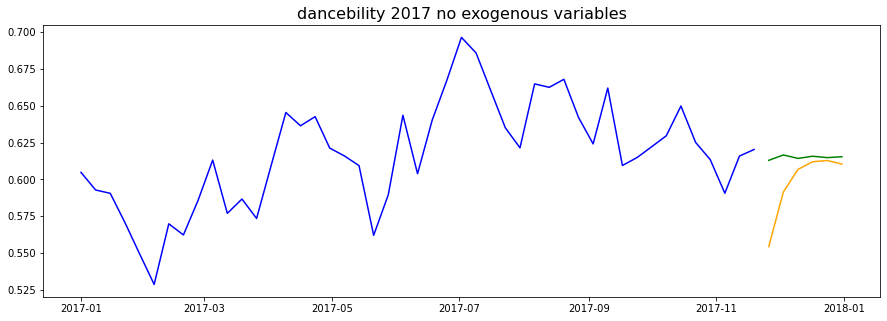

In [115]:
train_dance = it_rw_17['danceability'][0:47]
test_dance = it_rw_17['danceability'][47:]

sarima = SARIMAX(endog=train_dance, order=(1,1,2)).fit()

# fit ARIMA model
# sarima_fit = sarima.fit()

# get predictions for train and test sets 
preds_train = sarima.predict(params=sarima.params, start=train_dance.index[1], end=train_dance.index[-1], typ='levels')
preds_test = sarima.predict(params=sarima.params, start=test_dance.index[0], end=test_dance.index[-1], typ='levels')
    

train_rmse_dance_no_exog = mean_squared_error(train_dance[1::], preds_train)**0.5
print(train_rmse_dance_no_exog)

test_rmse_dance_no_exog = mean_squared_error(test_dance, preds_test)**0.5
print(test_rmse_dance_no_exog)

arima_plot(train_dance, test_dance, preds_test, title='dancebility 2017 no exogenous variables')

_SARIMAX model with exogenous variables: 4 main audio features that aren't danceability_

In [130]:
# exog = it_rw_17.loc[['mode', 'acousticness', 'valence', 'tempo']]

In [187]:
exog = it_rw_17.loc[:, ['mode', 'acousticness', 'valence']]

In [188]:
# exog[0:47]

0.025916229077650923
0.13104112426083286


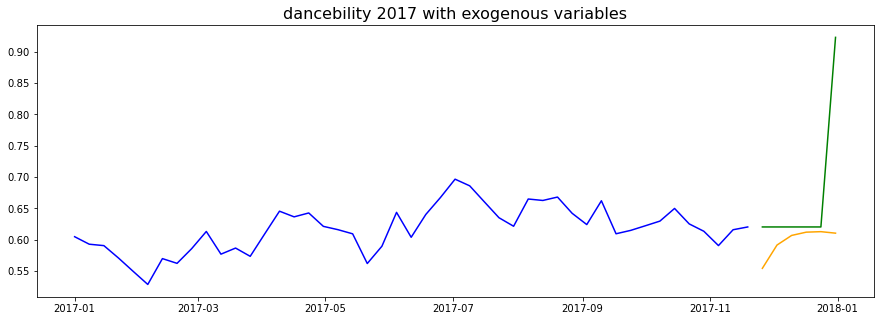

In [189]:
train_dance = it_rw_17['danceability'][0:47]
test_dance = it_rw_17['danceability'][47:]

sarima_ex = SARIMAX(endog=train_dance, exog=exog[0:47], order=(1,1,2), seasonal_order=(1,1,2,52)).fit()

# fit ARIMA model
# sarima_fit = sarima.fit()

# get predictions for train and test sets 
preds_train_ex = sarima_ex.predict(start=train_dance.index[1], end=train_dance.index[-1], typ='levels', exog=exog[0:47])
preds_test_ex = sarima_ex.predict(start=test_dance.index[0], end=test_dance.index[-1], typ='levels', exog=exog[47:])
    

train_rmse_dance_ex= mean_squared_error(train_dance[1::], preds_train_ex)**0.5
print(train_rmse_dance_ex)

test_rmse_dance_ex = mean_squared_error(test_dance, preds_test_ex)**0.5
print(test_rmse_dance_ex)

arima_plot(train_dance, test_dance, preds_test_ex, title='dancebility 2017 with exogenous variables')

0.025916229077650923
0.13104112426083286


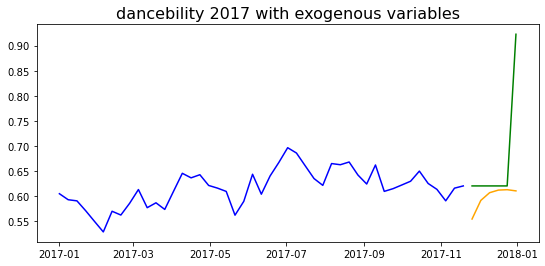

In [170]:
train_dance = it_rw_17['danceability'][0:47]
test_dance = it_rw_17['danceability'][47:]

sarima_ex = SARIMAX(endog=train_dance, exog=exog[0:47], order=(1,1,2), seasonal_order=(1,1,2,52)).fit()

# fit ARIMA model
# sarima_fit = sarima.fit()

# get predictions for train and test sets 
preds_train_ex = sarima_ex.predict(start=train_dance.index[1], end=train_dance.index[-1], typ='levels', exog=exog[0:47])
preds_test_ex = sarima_ex.predict(start=test_dance.index[0], end=test_dance.index[-1], typ='levels', exog=exog[47:])
    

train_rmse_dance_ex= mean_squared_error(train_dance[1::], preds_train_ex)**0.5
print(train_rmse_dance_ex)

test_rmse_dance_ex = mean_squared_error(test_dance, preds_test_ex)**0.5
print(test_rmse_dance_ex)

arima_plot(train_dance, test_dance, preds_test_ex, title='dancebility 2017 with exogenous variables', figsize=(9,4))

### Building, evaluating, plotting SARIMAX using a function 

In [303]:
def sarima_predict_plot(df, feature, year, exog_feat, order, seasonal_order, d=0, figsize=(15,5), title='title'):
    
    exog = exog_feat
     
#     exog = df.loc[:, exog_feat]   
        
        
#     exog = it_rw_17.loc[:, ['mode', 'acousticness', 'valence']]
    
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # instantiate and fit SARIMAX model 
    sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=(1,1,2,52)).fit()

    
    # find ndiffs for stationarity from ndiff dataframe
    # d = ndiff_df.loc[ndiff_df['audio_feature'] == ndiff_feature, 'ndiffs for stationarity'].iloc[0]

    # find order from arima parameters dataframe 
    # order = arima_param_df.loc[arima_param_df['audio_feature'] == ndiff_feature, 'order'].iloc[0]
    
    
    # get predictions for train and test sets 
    preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
    preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}) w/ exog features: {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}) w/ exog features: {test_rmse}')

# arima_plot(train_dance, test_dance, preds_test_ex, title='dancebility 2017 with exogenous variables')
    
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'exog_train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'exog_test_rmse'] = test_rmse
    
    # calculate residuals
    residuals = test - preds_test
    
#     return train, test, preds_test, residuals
                                                                                                       
# def arima_plot(train, test, preds_test, title='title', figsize=(15,5)):
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # plot confidence interval 
#     ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
#     plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

In [304]:
arima_param_df

,audio_feature,AIC,ndiffs(d),best_p,best_q,order,ARIMA_model,train_rmse,test_rmse,exog_train_rmse,exog_test_rmse,seasonal_order
1,danceability,-746.797730,1,1,2,"(1, 1, 2)","ARIMA(1,1,2)",0.025578,0.033635,0.027387,0.119624,"(3, 0, 0, 48)"
2,mode,-446.531723,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",0.070201,0.078988,0.092713,0.113885,"(1, 0, 1, 52)"
3,acousticness,-619.986170,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",0.038503,0.031290,0.244360,0.233753,"(1, 0, 2, 48)"
4,valence,-647.409633,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",0.035573,0.033325,0.462841,0.420787,"(0, 0, 1, 49)"
5,tempo,796.904884,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)",2.937925,7.120252,120.575313,101.827032,"(2, 0, 0, 49)"


In [305]:
five_features 

['danceability', 'mode', 'acousticness', 'valence', 'tempo']

Danceability train RMSE (2017) - ARIMA((1, 1, 2)) w/ exog features: 0.027387175551438752
Danceability test RMSE (2017) - ARIMA((1, 1, 2)) w/ exog features: 0.11962351709838295


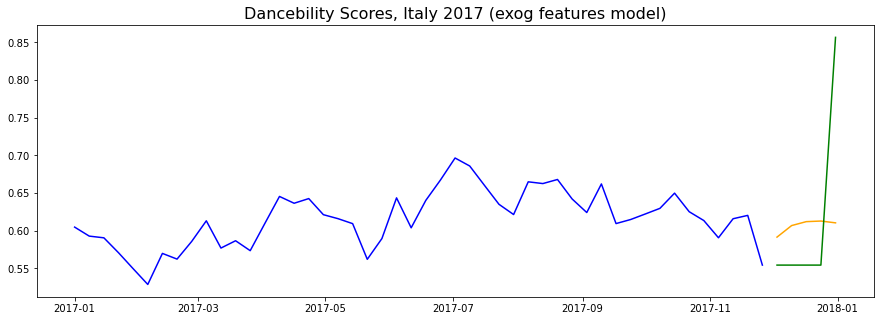

In [306]:
exog_dance = it_rw_17.loc[:, ['mode', 'acousticness', 'valence', 'tempo']]   

sarima_predict_plot(it_rw_17, 'danceability', 2017, exog_dance, order=(1,1,2), seasonal_order=(3, 0, 0, 48), d=1, title="Dancebility Scores, Italy 2017 (exog features model)")

In [236]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'tempo']

exog_mode = ['danceability', 'acousticness', 'valence', 'tempo']
exog_acoustic = ['danceability', 'mode', 'valence', 'tempo']
exog_valence = ['danceability', 'mode', 'acousticness', 'tempo']
exog_tempo = ['danceability', 'mode', 'acousticness', 'valence']

Mode train RMSE (2017) - ARIMA((4, 1, 3)) w/ exog features: 0.09271266333564915
Mode test RMSE (2017) - ARIMA((4, 1, 3)) w/ exog features: 0.11388507805713001


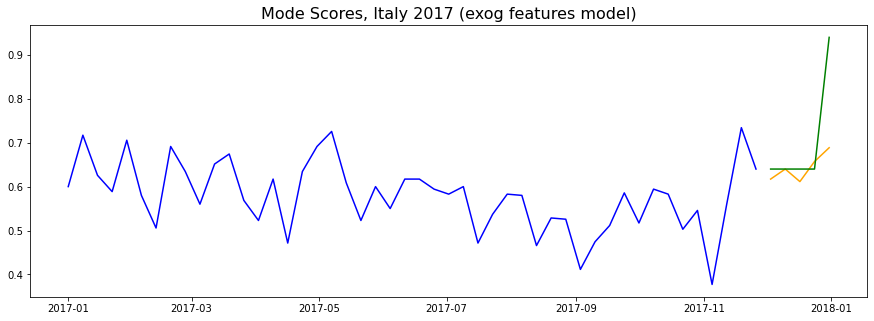

In [244]:
sarima_predict_plot(it_rw_17, 'mode', 2017, exog_feat=exog_mode, order=(4,1,3), seasonal_order=(4,1,3,52), d=1, title="Mode Scores, Italy 2017 (exog features model)")

Acousticness train RMSE (2017) - ARIMA((3, 0, 2)) w/ exog features: 0.24435996522129277
Acousticness test RMSE (2017) - ARIMA((3, 0, 2)) w/ exog features: 0.23375253777008645


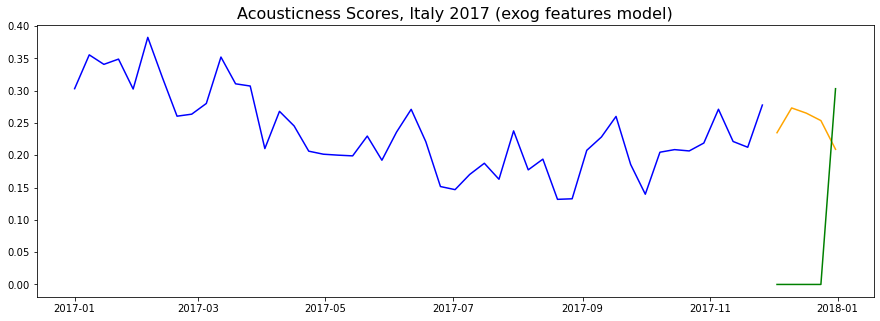

In [254]:
sarima_predict_plot(it_rw_17, 'acousticness', 2017, exog_acoustic, order=(3,0,2), seasonal_order=(2,0,2,2), d=0, title="Acousticness Scores, Italy 2017 (exog features model)")

Valence train RMSE (2017) - ARIMA((2, 0, 2)) w/ exog features: 0.46284087904438265
Valence test RMSE (2017) - ARIMA((2, 0, 2)) w/ exog features: 0.4207869191156114


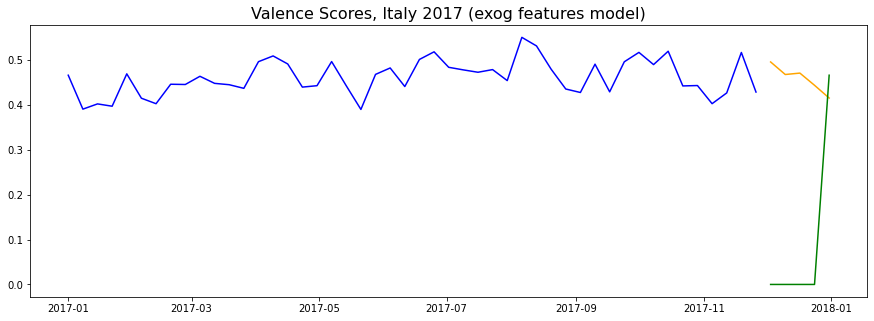

In [250]:
sarima_predict_plot(it_rw_17, 'valence', 2017, exog_valence, order=(2,0,2), seasonal_order=(2,0,2,52), d=0, title="Valence Scores, Italy 2017 (exog features model)")

Tempo train RMSE (2017) - ARIMA((2, 0, 2)) w/ exog features: 120.57531323452659
Tempo test RMSE (2017) - ARIMA((2, 0, 2)) w/ exog features: 101.82703211025701


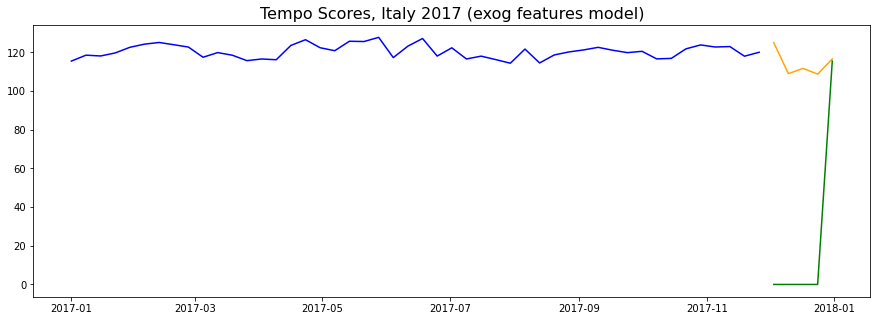

In [252]:
sarima_predict_plot(it_rw_17, 'tempo', 2017, exog_tempo, order=(2,0,2), seasonal_order=(2,0,2,52), d=0, title="Tempo Scores, Italy 2017 (exog features model)")

In [106]:
it_rw_17.head(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,...,0.005019,-0.237143,0.337877,0.117143,0.009925,0.052356,0.120898,0.003355,-0.07556,3.052389


In [102]:
type(it_rw_17[['mode', 'instrumentalness']])

pandas.core.frame.DataFrame

In [258]:
import time
t0 = time.time()
final_mae = 1000000000000
final_S = 0
final_D = 0
final_P = 0
final_Q = 0

train_values = it_rw_17['acousticness'][0:47]
test_values = it_rw_17['acousticness'][47:]

for S in range(48,53):
    for D in range(2):
        for P in range(4):
            for Q in range(4):
                print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                try:
                    sarima = SARIMAX(endog = train_values,
                                     order = (2, 0, 2),
                                     seasonal_order = (P, D, Q, S)).fit()

                    sarima_pred = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels')

#                     sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=(1,1,2,52)).fit()         
#                     preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
#                     preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])
                    
                    
                    
                    if mean_absolute_error(test_values, sarima_pred) < final_mae:
                        final_mae = mean_absolute_error(test_values, sarima_pred)
                        final_S = S
                        final_D = D
                        final_P = P
                        final_Q = Q
                        
                    print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_absolute_error(test_values, sarima_pred)} MAE.')
                    
                except:
                    print('problem!')
                    raise

print(f'The final model is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')

Checking (0, 0, 0, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 0, 48) model with 0.03832684166216647 MAE.
Checking (0, 0, 1, 48) at 1 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 1, 48) model with 0.030496067123513024 MAE.
Checking (0, 0, 2, 48) at 4 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 2, 48) model with 0.02582860730394708 MAE.
Checking (0, 0, 3, 48) at 24 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 3, 48) model with 0.022048135008915237 MAE.
Checking (1, 0, 0, 48) at 57 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 0, 48) model with 0.024355589919174192 MAE.
Checking (1, 0, 1, 48) at 59 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 1, 48) model with 0.01974993607938817 MAE.
Checking (1, 0, 2, 48) at 63 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 2, 48) model with 0.019137094843898153 MAE.
Checking (1, 0, 3, 48) at 76 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 3, 48) model with 0.02700615907284464 MAE.
Checking (2, 0, 0, 48) at 117 seconds.
We just 

KeyboardInterrupt: 

# THIS IS MY SARIMAX GRID SEARCH FUNCTION _(below)_

In [269]:
def find_sarima_parameters(df, feature, n_rows=47):    
    
    import time
    t0 = time.time()
    final_mae = 1000000000000
    final_S = 0
    final_D = 0
    final_P = 0
    final_Q = 0
    
    # find order from arima parameters dataframe 
    order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]

    train_values = df[feature][0:n_rows]
    test_values = df[feature][n_rows:]

    for S in range(48,53):
        for D in range(2):
            for P in range(4):
                for Q in range(4):
                    print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                    try:
                        sarima = SARIMAX(endog = train_values,
                                         order = order,
                                         seasonal_order = (P, D, Q, S)).fit()

                        sarima_pred = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels')

    #                     sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=(1,1,2,52)).fit()         
    #                     preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
    #                     preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])



                        if mean_absolute_error(test_values, sarima_pred) < final_mae:
                            final_mae = mean_absolute_error(test_values, sarima_pred)
                            final_S = S
                            final_D = D
                            final_P = P
                            final_Q = Q

                        print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_absolute_error(test_values, sarima_pred)} MAE and {mean_squared_error(test_values, sarima_pred)**0.5} RMSE.')

                    except:
                        print('problem!')
                        raise

    print()
    print(f'The final model for {feature} is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')
    print()

In [271]:
five_features

['danceability', 'mode', 'acousticness', 'valence', 'tempo']

In [279]:
for feature in five_features: 
    find_sarima_parameters(it_rw_17, feature)

Checking (0, 0, 0, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 0, 48) model with 0.016988168426071704 MAE and 0.026355071927261404 RMSE.
Checking (0, 0, 1, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 1, 48) model with 0.02121237711416731 MAE and 0.029786461353564858 RMSE.
Checking (0, 0, 2, 48) at 3 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 2, 48) model with 0.023185699539685467 MAE and 0.031241463912288554 RMSE.
Checking (0, 0, 3, 48) at 8 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 3, 48) model with 0.02270027324346104 MAE and 0.030897300056693097 RMSE.
Checking (1, 0, 0, 48) at 23 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 0, 48) model with 0.018211420831095355 MAE and 0.027654294547734295 RMSE.
Checking (1, 0, 1, 48) at 24 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 1, 48) model with 0.02520485133596854 MAE and 0.033054439798678226 RMSE.
Checking (1, 0, 2, 48) at 26 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 2, 48) model with 0.02529764787

In [276]:
# for feature in five_features:
#     find_sarima_parameters(rw_italy_17_19, feature)

In [277]:
# for feature in five_features:
#     find_sarima_parameters(rw_italy_20, feature)

The final model for danceability is SARIMAX(2, 0, 2)x(3, 0, 0, 48).

The final model for mode is SARIMAX(2, 0, 2)x(1, 0, 1, 52).

The final model for acousticness is SARIMAX(2, 0, 2)x(1, 0, 2, 48).

The final model for valence is SARIMAX(2, 0, 2)x(0, 0, 1, 49).

The final model for tempo is SARIMAX(2, 0, 2)x(2, 0, 0, 49).


#### Adding Seasonal Orders to `arima_param_df`

In [293]:
arima_param_df.loc[arima_param_df['audio_feature'] == 'danceability', 'seasonal_order'] = '(3, 0, 0, 48)'
arima_param_df.loc[arima_param_df['audio_feature'] == 'mode', 'seasonal_order'] = '(1, 0, 1, 52)'
arima_param_df.loc[arima_param_df['audio_feature'] == 'acousticness', 'seasonal_order'] = '(1, 0, 2, 48)'
arima_param_df.loc[arima_param_df['audio_feature'] == 'valence', 'seasonal_order'] = '(0, 0, 1, 49)'
arima_param_df.loc[arima_param_df['audio_feature'] == 'tempo', 'seasonal_order'] = '(2, 0, 0, 49)'

In [294]:
# works! 
# find_sarima_parameters(it_rw_17, 'acousticness')

In [295]:
arima_param_df

,audio_feature,AIC,ndiffs(d),best_p,best_q,order,ARIMA_model,train_rmse,test_rmse,exog_train_rmse,exog_test_rmse,seasonal_order
1,danceability,-746.797730,1,1,2,"(1, 1, 2)","ARIMA(1,1,2)",0.025578,0.033635,0.027387,0.119624,"(3, 0, 0, 48)"
2,mode,-446.531723,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",0.070201,0.078988,0.092713,0.113885,"(1, 0, 1, 52)"
3,acousticness,-619.986170,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",0.038503,0.031290,0.244360,0.233753,"(1, 0, 2, 48)"
4,valence,-647.409633,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",0.035573,0.033325,0.462841,0.420787,"(0, 0, 1, 49)"
5,tempo,796.904884,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)",2.937925,7.120252,120.575313,101.827032,"(2, 0, 0, 49)"


(216, 14)

In [ ]:
# sarima_params(alltime_rw_italy, 'danceability')

In [ ]:
import time
t0 = time.time()
final_mae = 1000000000000
final_S = 0
final_D = 0
final_P = 0
final_Q = 0

train_values = it_rw_17['acousticness'][0:47]
test_values = it_rw_17['acousticness'][47:]

for S in range(48,53):
    for D in range(2):
        for P in range(4):
            for Q in range(4):
                print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                try:
                    sarima = SARIMAX(endog = train_values,
                                     order = (2, 0, 2),
                                     seasonal_order = (P, D, Q, S)).fit()

                    sarima_pred = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels')

#                     sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=(1,1,2,52)).fit()         
#                     preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
#                     preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])
                    
                    
                    
                    if mean_absolute_error(test_values, sarima_pred) < final_mae:
                        final_mae = mean_absolute_error(test_values, sarima_pred)
                        final_S = S
                        final_D = D
                        final_P = P
                        final_Q = Q
                        
                    print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_absolute_error(test_values, sarima_pred)} MAE.')
                    
                except:
                    print('problem!')
                    raise

print(f'The final model is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')

Checking (0, 0, 0, 48) at 0 seconds.
Checking (0, 0, 1, 48) at 1 seconds.
Checking (0, 0, 2, 48) at 4 seconds.
Checking (0, 0, 3, 48) at 37 seconds.
Checking (1, 0, 0, 48) at 138 seconds.
Checking (1, 0, 1, 48) at 144 seconds.
Checking (1, 0, 2, 48) at 152 seconds.
Checking (1, 0, 3, 48) at 211 seconds.
Checking (2, 0, 0, 48) at 327 seconds.
Checking (2, 0, 1, 48) at 365 seconds.
Checking (2, 0, 2, 48) at 440 seconds.
Checking (2, 0, 3, 48) at 505 seconds.
Checking (3, 0, 0, 48) at 642 seconds.
Checking (3, 0, 1, 48) at 738 seconds.
Checking (3, 0, 2, 48) at 857 seconds.
Checking (3, 0, 3, 48) at 1046 seconds.
Checking (0, 1, 0, 48) at 1502 seconds.
Checking (0, 1, 1, 48) at 1508 seconds.
Checking (0, 1, 2, 48) at 1538 seconds.
Checking (0, 1, 3, 48) at 1645 seconds.
Checking (1, 1, 0, 48) at 2058 seconds.
Checking (1, 1, 1, 48) at 2164 seconds.
Checking (1, 1, 2, 48) at 2198 seconds.
Checking (1, 1, 3, 48) at 2311 seconds.
Checking (2, 1, 0, 48) at 2348 seconds.
Checking (2, 1, 1, 48)

### Building and plotting SARIMAX models 

In [ ]:
# is this the same function as the one I'm using for exog? confirm / combine!


def sarima_fit_predict_evaluate(df, feature, year, order, seasonal_order, d=0):
    
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    # d = ndiff_df.loc[ndiff_df['audio_feature'] == ndiff_feature, 'ndiffs for stationarity'].iloc[0]

    # find order from arima parameters dataframe 
    # order = arima_param_df.loc[arima_param_df['audio_feature'] == ndiff_feature, 'order'].iloc[0]
   
    # instantiate and fit ARIMA model
    sarima = SARIMAX(endog = train,
                     exog = ..., 
                     order = order,
                     seasonal_order = seasonal_order).fit()
    
    # get predictions for train and test sets 
    preds_train = sarima.predict(start=train.index[d], end=train.index[-1])
    preds_test = sarima.predict(start=test.index[0], end=test.index[-1])
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')
    
    # calculate and print MAE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'test_rmse'] = test_rmse
    
    # calculate residuals
    residuals = test - preds_test
    
    return train, test, preds_test, residuals